In mobile games, especially those following the free-to-play business model, optimization is extremely important. The main reason for this is the increasing level of competition in the mobile gaming industry. According to the changing strategy, in addition to adding new game features, there is now also an emphasis on maximizing the benefits of existing game features. 

<h1 style="color: pink;">1) Project Goal</h1>
For example, in a match-3 game players progress through levels and occasionally encounter gates that require them to wait a significant amount of time or make an in-app purchase to continue. These gates are designed not only to drive revenue through in-app purchases but also to provide players with an enforced break, which ideally enhances their overall enjoyment and prolongs their engagement with the game.


. 
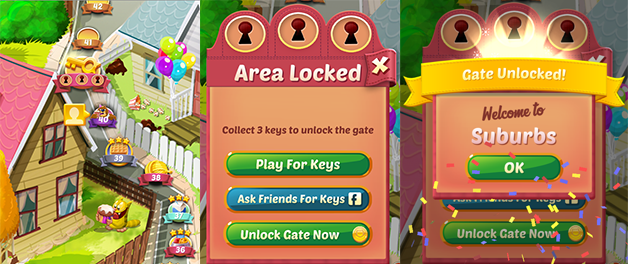


### Problem:
__Where should the gate be placed to optimize player retention and revenue?__ The initial gate was set at level 30, but an A/B test is being conducted to assess the impact of moving this gate to level 40. The key focus is on understanding how this change affects player retention.



1. **Gate at Level 30:**
   - **Advantages:**
     - *Early Revenue Generation:* Players encounter the gate sooner, which could lead to more frequent in-app purchases early in their gaming experience.
     - *Immediate Monetization:* An earlier gate might prompt players to spend money or wait sooner, potentially generating revenue more quickly.
   - **Disadvantages:**
     - *Potential Drop in Retention:* An early gate might frustrate players who are not yet fully invested in the game, potentially decreasing retention as players may quit before becoming deeply engaged.
     - *Premature Breaks:* An early gate could disrupt gameplay flow, causing players to disengage if they feel pressured to pay or wait too soon.

2. **Gate at Level 40:**
   - **Advantages:**
     - *Extended Engagement:* Players who reach level 40 are likely more invested in the game, making them potentially more willing to spend money or wait.
     - *Higher Revenue Potential:* By delaying the gate, players may be more inclined to spend money after investing more time in the game, potentially increasing revenue.
   - **Disadvantages:**
     - *Delayed Monetization:* With the gate set later, revenue generation is postponed. Players will reach this barrier only after progressing further, which may delay immediate revenue impact.
     - *Risk of Attrition:* If the gate presents a significant challenge or requires a long wait, players might quit before reaching level 40, leading to a loss in potential revenue and reduced retention.


While product managers may have insights based on experience and competitive analysis, determining the truly *best* answer is not always straightforward. Considering the entire game as a funnel, it is crucial to minimize player loss from the very first stage (e.g., the tutorial process). To identify the optimal gate placement, **A/B testing** is used. This method allows for empirical analysis of how different gate placements impact player retention and revenue, helping to determine the most effective strategy based on actual data.


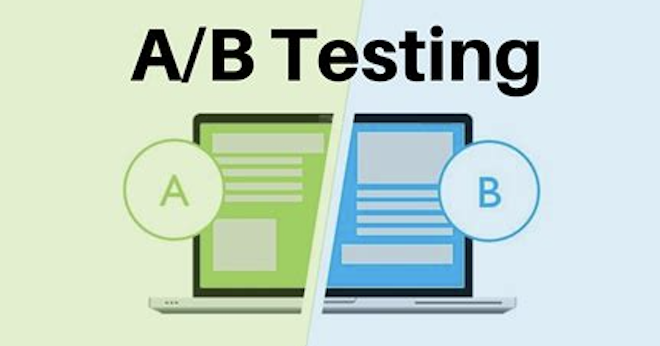


<h1 style="color: pink;">2) Data Overview </h1>
The dataset consists of 90,189 players who installed the game during the A/B test period. The key variables in the dataset are:

- **userid:** A unique identifier for each player.
- **version:** Indicates the group to which the player was assigned:
  - `gate_30`: Players in the control group with a gate at level 30.
  - `gate_40`: Players in the experimental group with a gate moved to level 40.
- **sum_gamerounds:** The total number of game rounds played by the player during the first 14 days after installation.
- **retention_1:** Whether the player returned to play 1 day after installation (binary: 0 = No, 1 = Yes).
- **retention_7:** Whether the player returned to play 7 days after installation (binary: 0 = No, 1 = Yes).

Players were randomly assigned to either the `gate_30` or `gate_40` group upon installing the game.

Let's load the data and take a closer look!

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
import warnings
warnings.filterwarnings("ignore")


# Reading the data set
df = pd.read_csv("../input/mobile-games-ab-testing-cookie-cats/cookie_cats.csv")

# Showing the first 5 rows
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


How many different players are there in this data?


In [2]:
df["userid"].nunique()

90189

Now let's see how many players played at each level.

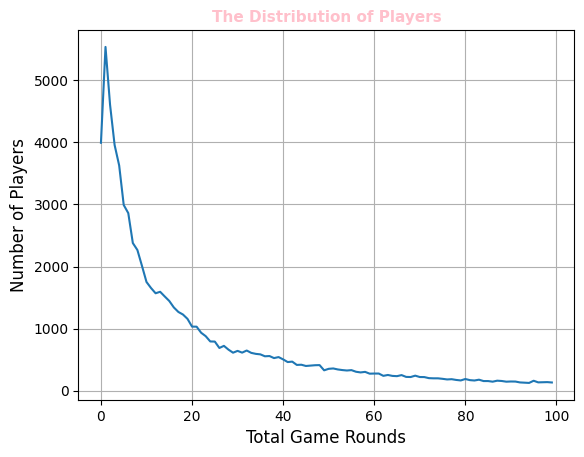

In [3]:
grouped_data = df.groupby("sum_gamerounds")["userid"].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = grouped_data.head(100).plot()
plt.title("The Distribution of Players", fontweight="bold", size=11, color="pink")
plt.xlabel("Total Game Rounds", size=12)
plt.ylabel("Number of Players", size=12)
plt.grid(True)
plt.show()

In [4]:
len(df[df["sum_gamerounds"] == 0])

3994

As we can see from the graph, there are many players who did not play after installing the game. 3994 players never played the game, just installed it.Several reasons might explain this situation:

* They might not have had enough free time to play the game.
* Users might prefer or are already engaged with other games.
* Some users may not have found the app appealing.


<h2>Outliers</h2>

In [5]:
df.groupby("version")["sum_gamerounds"].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


In the 'gate_30', we observe that the maximum value (49,854) is significantly higher than the mean and standard deviation, this maximum value is excessively large, indicating that it could be an outlier.

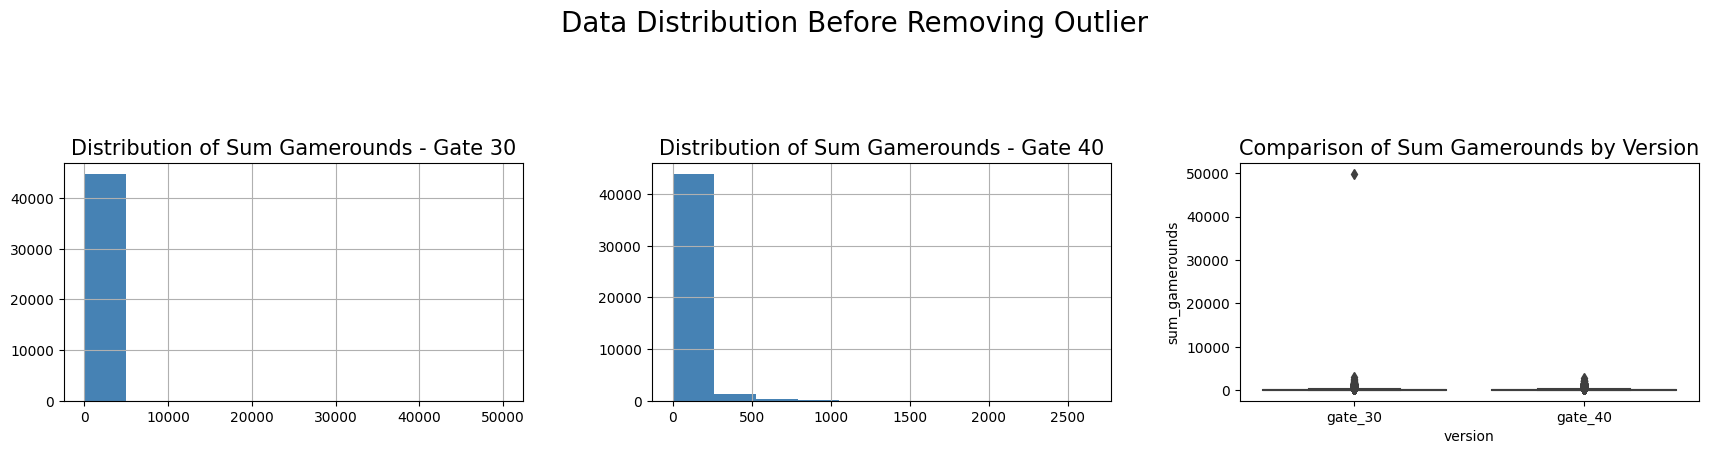

In [6]:
# Create a subplot with three different plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram for sum_gamerounds of "gate_30"
df[df.version == "gate_30"].hist("sum_gamerounds", ax=axes[0], color="steelblue")
axes[0].set_title("Distribution of Sum Gamerounds - Gate 30", fontsize=15)

# Histogram for sum_gamerounds of "gate_40"
df[df.version == "gate_40"].hist("sum_gamerounds", ax=axes[1], color="steelblue")
axes[1].set_title("Distribution of Sum Gamerounds - Gate 40", fontsize=15)

# Boxplot showing distribution of sum_gamerounds for both groups
sns.boxplot(x=df.version, y=df.sum_gamerounds, ax=axes[2])
axes[2].set_title("Comparison of Sum Gamerounds by Version", fontsize=15)

# Common title and layout adjustment
plt.suptitle("Data Distribution Before Removing Outlier", fontsize=20)
plt.tight_layout(pad=4)
plt.show()

There is a single data point in Gate 40 with an extremely high number of game rounds. This data point is considered an "outlier" because it is significantly distant from all other data points. It can be inferred that this player interacted with the game in a manner that is quite different from other players.

__Let' drop this observation.__

In [7]:
df = df[df["sum_gamerounds"] < df["sum_gamerounds"].max()]

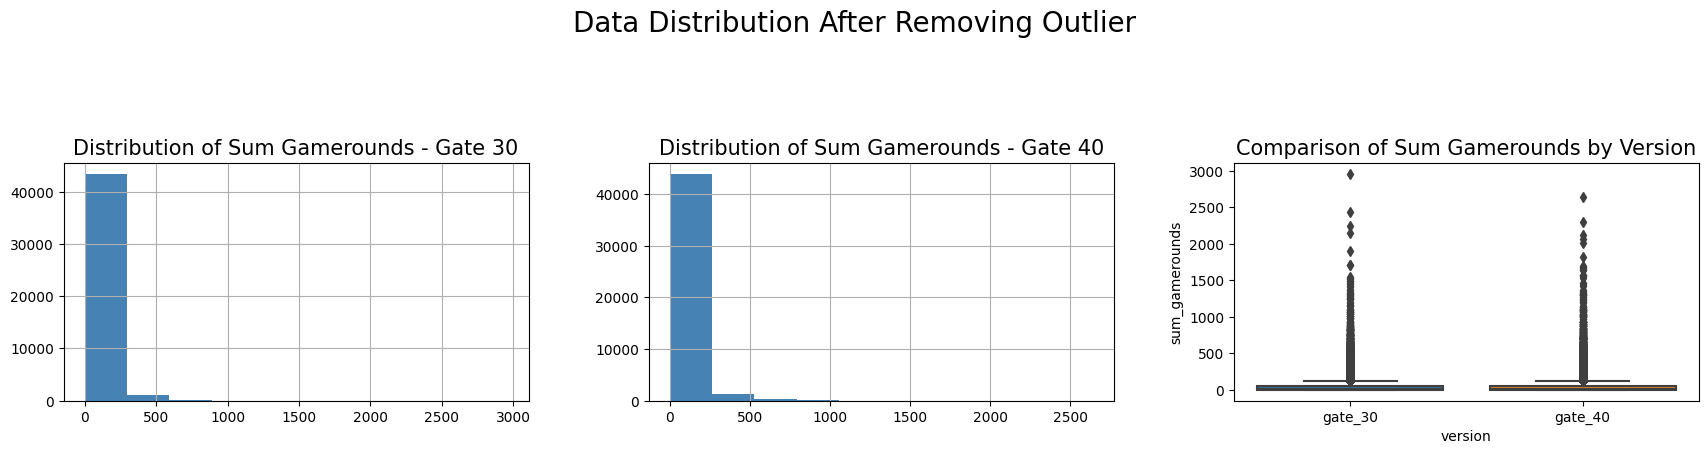

In [8]:
# Create a subplot with three different plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram for sum_gamerounds of "gate_30"
df[df.version == "gate_30"].hist("sum_gamerounds", ax=axes[0], color="steelblue")
axes[0].set_title("Distribution of Sum Gamerounds - Gate 30", fontsize=15)

# Histogram for sum_gamerounds of "gate_40"
df[df.version == "gate_40"].hist("sum_gamerounds", ax=axes[1], color="steelblue")
axes[1].set_title("Distribution of Sum Gamerounds - Gate 40", fontsize=15)

# Boxplot showing distribution of sum_gamerounds for both groups
sns.boxplot(x=df.version, y=df.sum_gamerounds, ax=axes[2])
axes[2].set_title("Comparison of Sum Gamerounds by Version", fontsize=15)

# Common title and layout adjustment
plt.suptitle("Data Distribution After Removing Outlier", fontsize=20)
plt.tight_layout(pad=4)
plt.show()

<h2>Retention Rate</h2>

Retention rates refer to the percentage of players who return to the game after their installation. It's commonly measured at specific intervals, such as 1-day, 7-days, or 30-days after the first play. High retention rates indicate that players find the game engaging and are likely to continue playing over time.

Let's calculate the overall 1-day and 7-days retention rates.

In [9]:
df_retention = df[["retention_1", "retention_7"]].mean() * 100

print(f"Overall 1-day retention rate: {round(df_retention['retention_1'], 2)}%")
print(f"Overall 7-days retention rate: {round(df_retention['retention_7'], 2)}%")


Overall 1-day retention rate: 44.52%
Overall 7-days retention rate: 18.61%


The game keeps about 46.5% of players coming back on the first day, which is good. After a week, around 19.4% return, which is normal as players usually drop off over time. The game is good at getting players to return initially but could improve to keep them interested for longer.

Let's examine the number of users, the 1-day retention rate, the 7-day retention rate, and the average number of game rounds played by players in each version.

In [10]:
df.groupby("version").agg({"userid" : "count",
                          "retention_1" : "mean",
                          "retention_7" : "mean",
                          "sum_gamerounds" : "mean"})

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44699,0.448198,0.190183,51.342111
gate_40,45489,0.442283,0.182000,51.298776


* Both versions have similar 1-day and 7-days retention rates, with gate_30 being slightly better.
* gate_30 players play a bit more rounds on average compared to gate_40 players.
* Overall, there are only minor differences between the two versions.

* The data suggests that keeping the gate at level 30 might be preferable, but how statistically significant is this finding? Is there a real difference between the two variants? Can we predict that gate_40 will consistently result in lower retention rates in the future?


# 3) A/B Testing 

Let's  use the **sum_gamerounds** for the A/B testing. This variable represents the total number of game rounds played by players in each variant, which indicates player progression in the game.

1. **Formulate Hypothesis**  
   **H0:** Null hypothesis. There is no statistical difference between the two groups. \( M1 = M2 \)

2. **Check Assumptions**  
   - **Normality Assumption:** Shapiro test  
   - **Homogeneity of Variance:** Levene test

3. **Apply Hypotheses**

   - If assumptions are met:  
     **Independent Two-Sample T-Test** (parametric test)  
     T-test

   - If normality is not met:  
     **Mann-Whitney U Test** (non-parametric test)

   - If normality is met but homogeneity is not:  
     **T-test** (equal_var = False)

4. **P-value**  
   - If \( p-value < 0.05 \), reject \( H0 \)  
   - If \( p-value > 0.05 \), fail to reject \( H0 \)

__Let's create a function according to these steps.__

This function, `ab_test`, is designed to perform A/B testing for comparing two groups based on a specified variable. The function takes the following parameters:

- **data**: The dataset containing the information for the test.
- **group_col**: The column name that specifies the groups to be compared.
- **value_col**: The column name containing the values on which the test is performed.
- **group1**: The label for the first group.
- **group2**: The label for the second group.



In [11]:
def ab_testing(df, group_column, value_column, group1, group2):
    # Filter data for the two groups
    group1_data = df[df[group_column] == group1][value_column]
    group2_data = df[df[group_column] == group2][value_column]
    
    # Check assumptions
    normality_group1 = shapiro(group1_data)[1] > 0.05
    normality_group2 = shapiro(group2_data)[1] > 0.05
    var_homogeneity = levene(group1_data, group2_data)[1] > 0.05
    
    # Perform tests
    if normality_group1 and normality_group2:
        if var_homogeneity:
            stat, p_value = ttest_ind(group1_data, group2_data, equal_var=True)
        else:
            stat, p_value = ttest_ind(group1_data, group2_data, equal_var=False)
    else:
        stat, p_value = mannwhitneyu(group1_data, group2_data)
    
    # Calculate mean difference
    mean_diff = group1_data.mean() - group2_data.mean()
    
    # Create and return conclusion string
    if p_value < 0.05:
        result = (
            f"There is a statistically significant difference between the two groups. "
            f"The mean value for {group1} is {group1_data.mean():.4f} compared to {group2} with a mean value of {group2_data.mean():.4f}."
        )
    else:
        result = (
            f"There is no statistically significant difference between the two groups. "
            f"The mean value for {group1} is {group1_data.mean():.4f} compared to {group2} with a mean value of {group2_data.mean():.4f}."
        )
    
    return result

In [12]:
ab_testing(df, 'version', 'sum_gamerounds', 'gate_30', 'gate_40')


'There is no statistically significant difference between the two groups. The mean value for gate_30 is 51.3421 compared to gate_40 with a mean value of 51.2988.'

# 4) Conclusion

Since there is no significant difference between gate_30 and gate_40, we can say that transitioning to gate_40 does not provide a meaningful improvement based on the current data. As we observed in previous analyses and understood after the A/B testing, there is no point in moving the gate from level 30 to level 40.